In [3]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import cm

from scipy.stats import mode
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import pearsonr as corr
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

global_seed = 20230831

from main_cifar10 import *

Using device: cuda
Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/cool_klindt/PerceptualSimilarity/lpips/weights/v0.1/alex.pth


In [4]:
log_dir = 'results/test4/'
with open(os.path.join(log_dir, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)

results['layer1'].keys()

dict_keys(['output_shape', 'activations', 'activations_normed', 'kmeans_num_dic', 'kmeans_128', 'kmeans_128dist', 'kmeans_256', 'kmeans_256dist', 'kmeans_512', 'kmeans_512dist', 'data_train', 'data_test', 'data_train_kmeans_128', 'data_test_kmeans_128', 'data_train_kmeans_256', 'data_test_kmeans_256', 'data_train_kmeans_512', 'data_test_kmeans_512', 'probabilities', 'probabilities_kmeans_128', 'probabilities_kmeans_256', 'probabilities_kmeans_512', 'monosemanticity', 'monosemanticity_kmeans_128', 'monosemanticity_kmeans_256', 'monosemanticity_kmeans_512', 'kmeans_128_top', 'kmeans_128_topdist', 'data_train_kmeans_128_top', 'data_test_kmeans_128_top', 'monosemanticity_kmeans_128_top', 'kmeans_128_bottom', 'kmeans_128_bottomdist', 'data_train_kmeans_128_bottom', 'data_test_kmeans_128_bottom', 'monosemanticity_kmeans_128_bottom', 'kmeans_256_top', 'kmeans_256_topdist', 'data_train_kmeans_256_top', 'data_test_kmeans_256_top', 'monosemanticity_kmeans_256_top', 'kmeans_256_bottom', 'kmeans_2

In [5]:
# using the topK of all neurons
k = 10
ind_topk = np.argsort(results['layer1']['activations'], 0)[-k:]
ind_topk = list(set(ind_topk.flatten()))
num_sample = len(ind_topk)
print(1 - num_sample / (256 * k), 'duplicates')


ind_sample = np.array(ind_topk)
X = results['inputs'][ind_sample].copy()
Y = results['layer1']['activations'][ind_sample].copy()

data_train, _ = get_mei_data(Y, X)
scores = -get_monosemanticity(data_train)
c = corr(
    -results['layer1']['monosemanticity'],
    scores
)[0]
print('num_sample', num_sample, 'corr MI(all) vs MI_5(sample)', c)

data_train, _ = get_mei_data(Y, X, num_train=10)
scores = -get_monosemanticity(data_train)
c = corr(
    -results['layer1']['monosemanticity'],
    scores
)[0]
print('corr MI(all) vs MI_10(sample)', c)


0.22148437499999996 duplicates
num_sample 1993 corr MI(all) vs MI_5(sample) 0.9999999999999999
corr MI(all) vs MI_10(sample) 0.7896453878665433


In [6]:
D = np.zeros((num_sample, num_sample))
for i in range(num_sample):
    out = lpips_metric(X[i:i + 1], X[i + 1:])
    D[i, i + 1:] = out.copy()
    if not i % 100:
        print(i, out.shape)

0 (1992,)
100 (1892,)
200 (1792,)
300 (1692,)
400 (1592,)
500 (1492,)
600 (1392,)
700 (1292,)
800 (1192,)
900 (1092,)
1000 (992,)
1100 (892,)
1200 (792,)
1300 (692,)
1400 (592,)
1500 (492,)
1600 (392,)
1700 (292,)
1800 (192,)
1900 (92,)


In [7]:
# Make symmetric
D += D.T

In [38]:

Z = TSNE(
    n_components=2, 
    #learning_rate='auto', 
    verbose=True,
    metric='precomputed',
    init='random',
    perplexity=10.0,
    random_state=42,
).fit_transform(D)
Z.shape

/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1993 samples in 0.008s...
[t-SNE] Computed neighbors for 1993 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1993
[t-SNE] Computed conditional probabilities for sample 1993 / 1993
[t-SNE] Mean sigma: 0.079851
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.542671
[t-SNE] KL divergence after 1000 iterations: 1.813467


(1993, 2)

[Text(1, 0, 'plane'),
 Text(1, 1, 'car'),
 Text(1, 2, 'bird'),
 Text(1, 3, 'cat'),
 Text(1, 4, 'deer'),
 Text(1, 5, 'dog'),
 Text(1, 6, 'frog'),
 Text(1, 7, 'horse'),
 Text(1, 8, 'ship'),
 Text(1, 9, 'truck')]

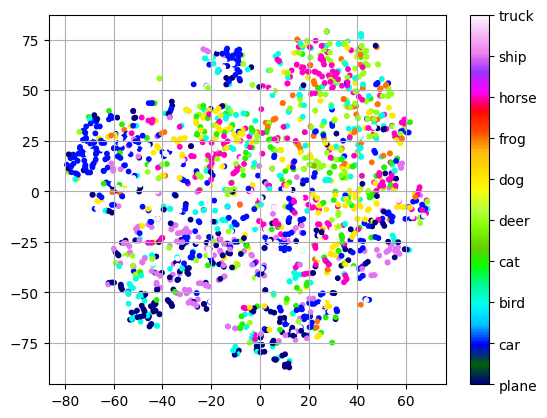

In [39]:
plt.scatter(
        *Z.T, 
        s=10,
        c=results['labels'][ind_sample], 
        cmap='gist_ncar'
    )
plt.grid()
cbar = plt.colorbar(ticks=np.arange(10))
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
cbar.ax.set_yticklabels(list(classes))

color by average image color

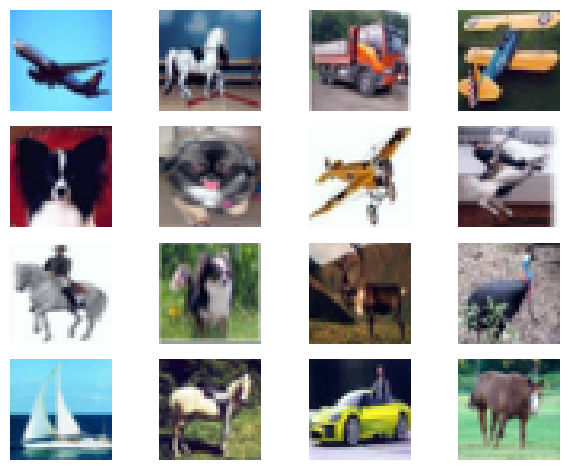

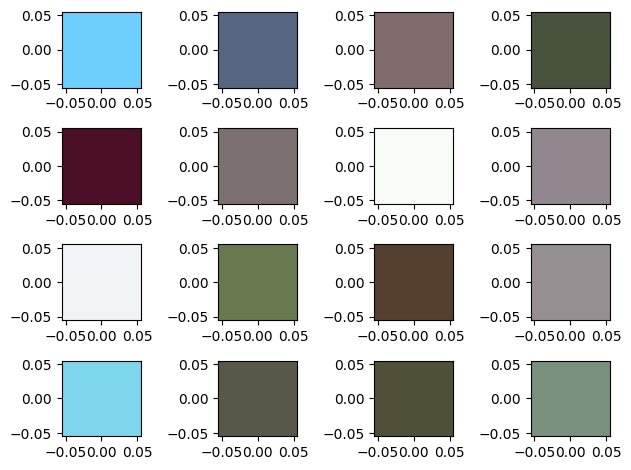

In [56]:
for i in range(16):
    plt.subplot(4, 4, i + 1)
    imshow(X[i])
plt.tight_layout()
plt.show()

for i in range(16):
    plt.subplot(4, 4, i + 1)
    tmp = X[i].copy()
    tmp -= np.min(tmp)
    tmp /= np.max(tmp)
    rgb = np.median(tmp, (1, 2))
    plt.plot(0, 0, '.', markersize=300, color=rgb)
plt.tight_layout()
plt.show()

In [65]:
colors = np.zeros((X.shape[0], 3))
for i in range(X.shape[0]):
    tmp = X[i].copy()
    tmp -= np.min(tmp)
    tmp /= np.max(tmp)
    colors[i] = np.median(tmp, (1, 2))
colors.shape

(1993, 3)

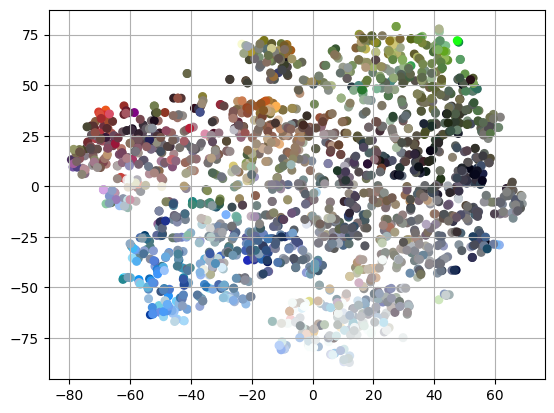

In [70]:
plt.scatter(
        *Z.T, 
        s=30,
        c=colors, 
    )
plt.grid()

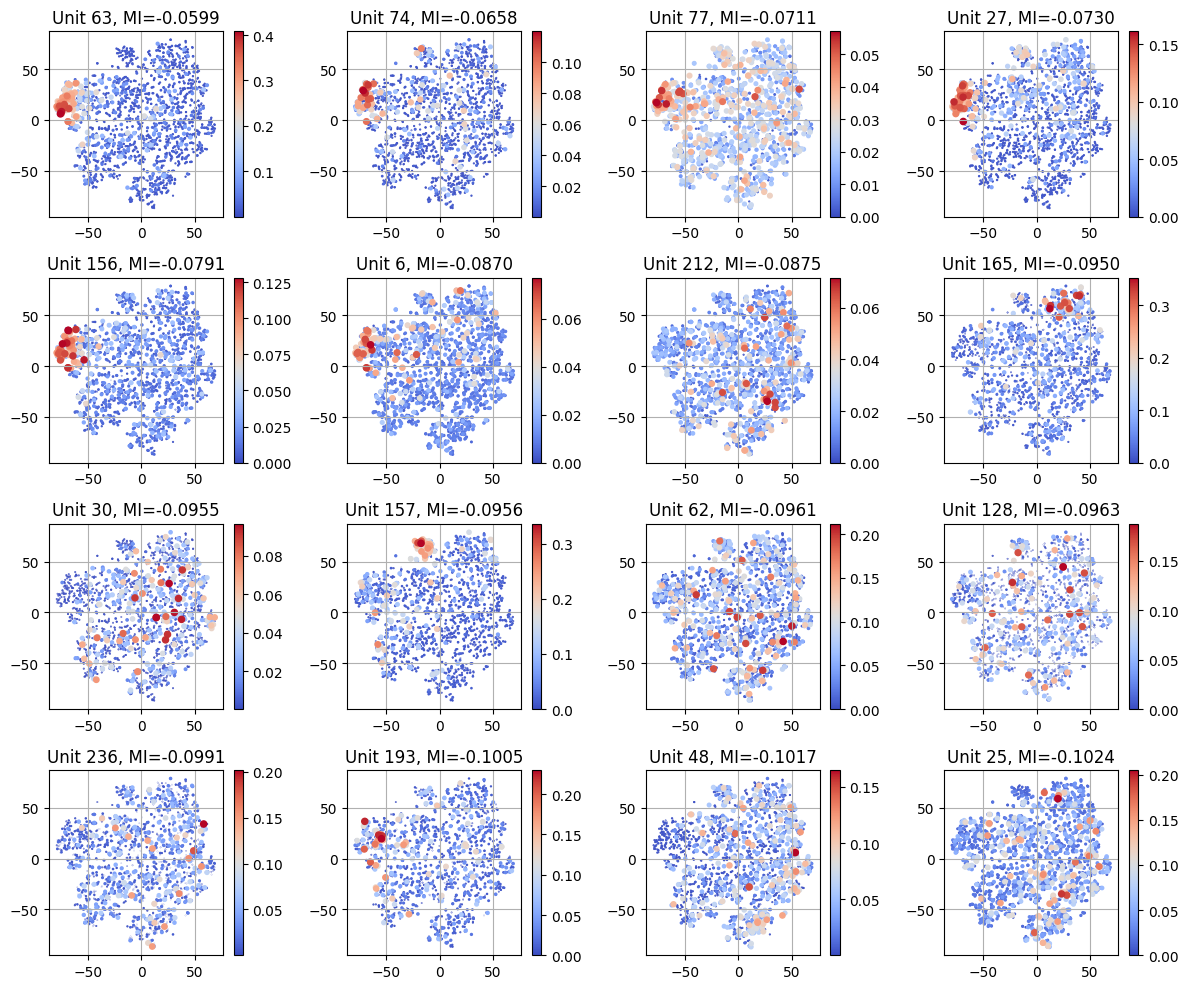

In [71]:
ind_sort = np.argsort(results['layer1']['monosemanticity'])
plt.figure(figsize=(12, 10))
for i in range(16):
    ind = ind_sort[i]
    plt.subplot(4, 4, i + 1)
    c = Y[:, ind].copy()
    ind_sort2 = np.argsort(c)
    plt.scatter(
        *Z[ind_sort2].T, 
        #s=3, 
        s=c[ind_sort2] * 20 / np.max(c),
        c=c[ind_sort2], 
        cmap='coolwarm'
    )
    plt.colorbar()
    plt.grid()
    plt.title('Unit %s, MI=%.4f' % (ind, - results['layer1']['monosemanticity'][ind]))
plt.tight_layout()
plt.show()

# Compare MI and Embedding

In [10]:
Z.shape, Y.shape, X.shape

((1993, 2), (1993, 256), (1993, 3, 32, 32))

In [24]:
def get_mei_data(activations, inputs, num_train=5, num_test=5):
    "Get most activating images as train and test for lpips"
    num_unit = activations.shape[1]
    data_train = np.zeros((num_unit, num_train, inputs.shape[1]))
    data_test = np.zeros((num_unit, num_test, inputs.shape[1]))
    for i in range(num_unit):
        y = activations[:, i].copy()
        ind_sort = np.argsort(y)[::-1]
        data_train[i] = inputs[ind_sort[:num_train]].copy()
        data_test[i] = inputs[ind_sort[num_train:num_train + num_test]].copy()
    return data_train, data_test

def get_monosemanticity(data_train):
    # Compute all pairwise distances and return average, lower is better
    num_unit = data_train.shape[0]
    #num_train = data_train.shape[1]
    scores = np.zeros(num_unit)
    for i in range(num_unit):
        similarities = np.sum((data_train[i, None] - data_train[i, :, None]) ** 2, -1)
        similarities = np.sqrt(similarities)
        #similarities = lpips_metric(data_train[i], data_train[i])
        scores[i] = np.mean(similarities)
    return scores

In [13]:
data_train, data_test = get_mei_data(Y, Z, num_train=5, num_test=5)
data_train.shape

(256, 5, 2)

In [22]:
# Embedding MI
z_scores = get_monosemanticity(data_train)
z_scores.shape

(256,)

Text(0, 0.5, 'MI Score (in embedding space)')

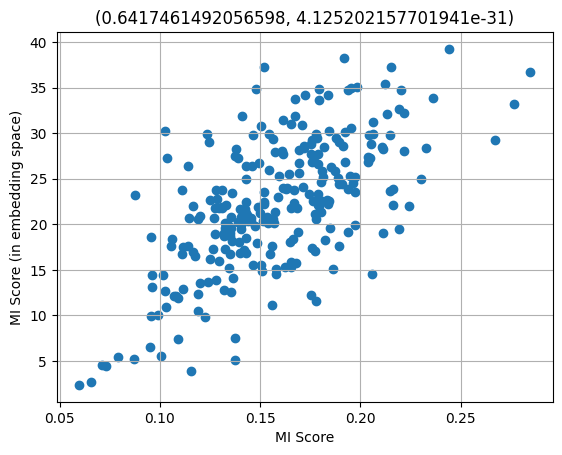

In [24]:
plt.scatter(
    results['layer1']['monosemanticity'],
    z_scores
)
plt.title(corr(
    results['layer1']['monosemanticity'],
    z_scores
))
plt.grid()
plt.xlabel('MI Score')
plt.ylabel('MI Score (in embedding space)')

In [ ]:
num_rep = 5
perplexities = [1, 3, 5, 10, 30, 50, 100]
corrs = np.zeros((len(perplexities), num_rep))

for rep in range(num_rep):
    for i, perplexity in enumerate(perplexities):
        Z = TSNE(
            n_components=2, 
            #learning_rate='auto', 
            verbose=False,
            metric='precomputed',
            init='random',
            perplexity=perplexity,
            random_state=42 + rep,
        ).fit_transform(D)
        data_train, _ = get_mei_data(Y, Z, num_train=5, num_test=5)
        z_scores = get_monosemanticity(data_train)
        corrs[i, rep] = corr(
            results['layer1']['monosemanticity'],
            z_scores
        )[0]
        print('rep', rep, 'perplexity', perplexity, corrs[i, rep])

    

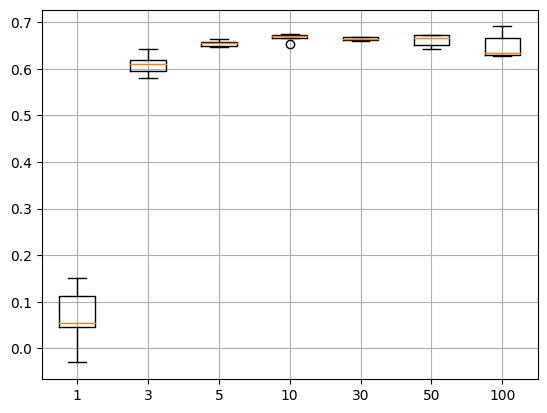

In [40]:
plt.boxplot(corrs.T)
plt.xticks(np.arange(len(perplexities)) + 1, perplexities)
plt.grid()

In [43]:
# tsne more dim
Z = TSNE(
    n_components=3, 
    #learning_rate='auto', 
    verbose=False,
    metric='precomputed',
    init='random',
    perplexity=10,
    random_state=42 + rep,
).fit_transform(D)
data_train, _ = get_mei_data(Y, Z, num_train=5, num_test=5)
print(Z.shape, data_train.shape)
z_scores = get_monosemanticity(data_train)
corr(
    results['layer1']['monosemanticity'],
    z_scores
)[0]

    

/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


(1993, 3) (256, 5, 3)


0.6628099377400367

In [72]:
# PCA
u, s, v = np.linalg.svd(D)
Z = u[:, :2].copy()
data_train, _ = get_mei_data(Y, Z, num_train=5, num_test=5)
print(Z.shape, data_train.shape)
z_scores = get_monosemanticity(data_train)
corr(
    results['layer1']['monosemanticity'],
    z_scores
)[0]

    

(1993, 2) (256, 5, 2)


0.7048903376866873

Text(0, 0.5, 'MI Score (in embedding space)')

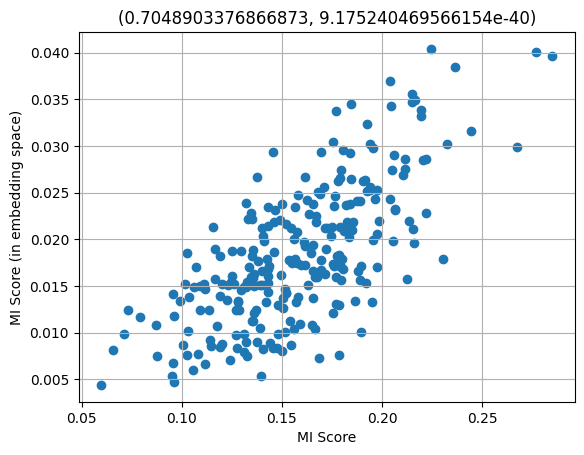

In [73]:
plt.scatter(
    results['layer1']['monosemanticity'],
    z_scores
)
plt.title(corr(
    results['layer1']['monosemanticity'],
    z_scores
))
plt.grid()
plt.xlabel('MI Score')
plt.ylabel('MI Score (in embedding space)')

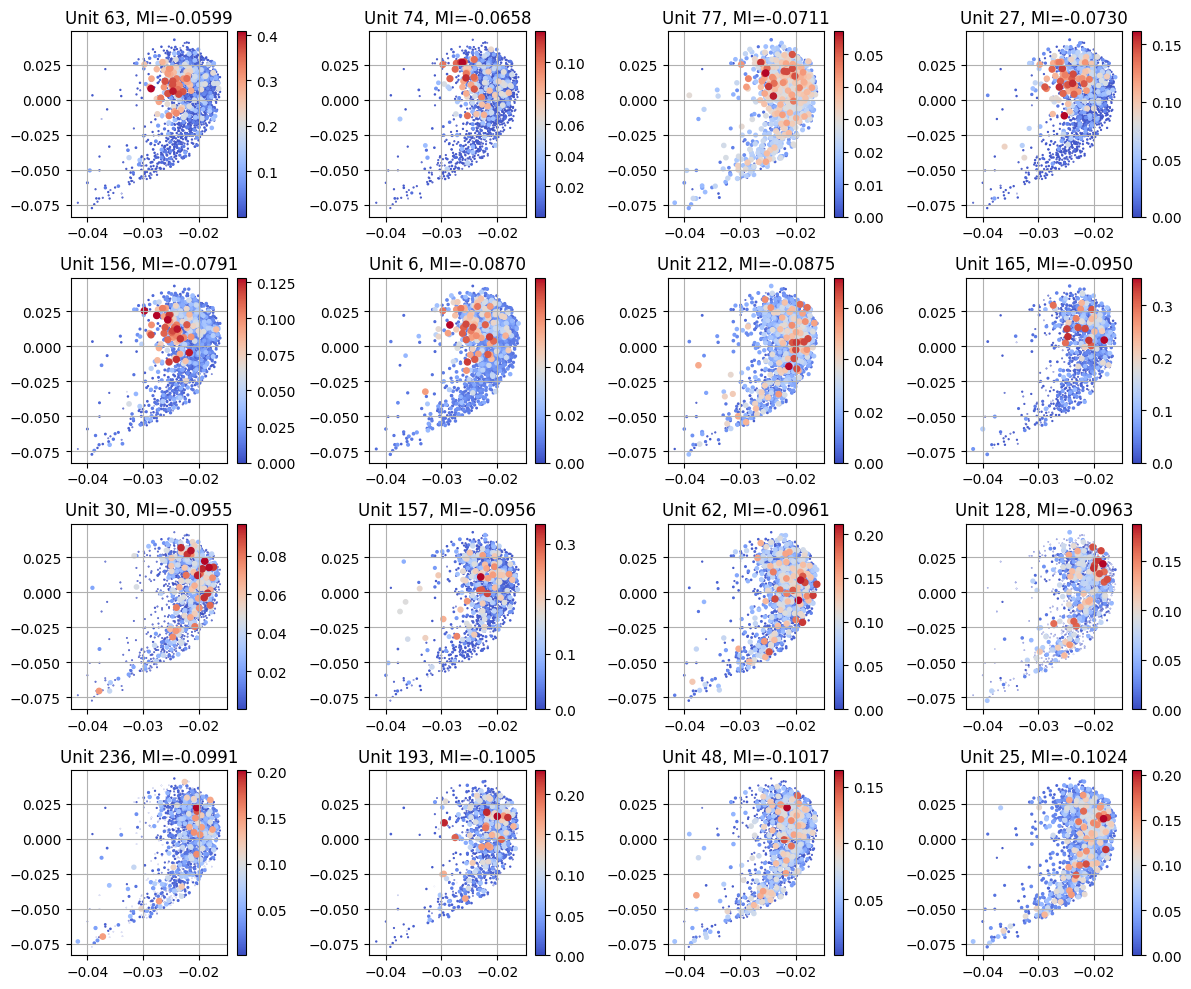

In [74]:
ind_sort = np.argsort(results['layer1']['monosemanticity'])
plt.figure(figsize=(12, 10))
for i in range(16):
    ind = ind_sort[i]
    plt.subplot(4, 4, i + 1)
    c = Y[:, ind].copy()
    ind_sort2 = np.argsort(c)
    plt.scatter(
        *Z[ind_sort2].T, 
        #s=3, 
        s=c[ind_sort2] * 20 / np.max(c),
        c=c[ind_sort2], 
        cmap='coolwarm'
    )
    plt.colorbar()
    plt.grid()
    plt.title('Unit %s, MI=%.4f' % (ind, - results['layer1']['monosemanticity'][ind]))
plt.tight_layout()
plt.show()

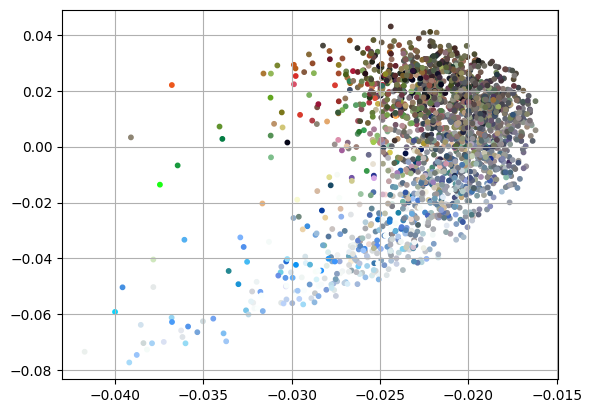

In [77]:
plt.scatter(
        *Z.T, 
        s=10,
        c=colors, 
    )
plt.grid()

In [78]:
# PCA
u, s, v = np.linalg.svd(D)
Z = u[:, :10].copy()
data_train, _ = get_mei_data(Y, Z, num_train=5, num_test=5)
print(Z.shape, data_train.shape)
z_scores = get_monosemanticity(data_train)
corr(
    results['layer1']['monosemanticity'],
    z_scores
)[0]

(1993, 10) (256, 5, 10)


0.8826737857678152

Text(0, 0.5, 'MI Score (in embedding space)')

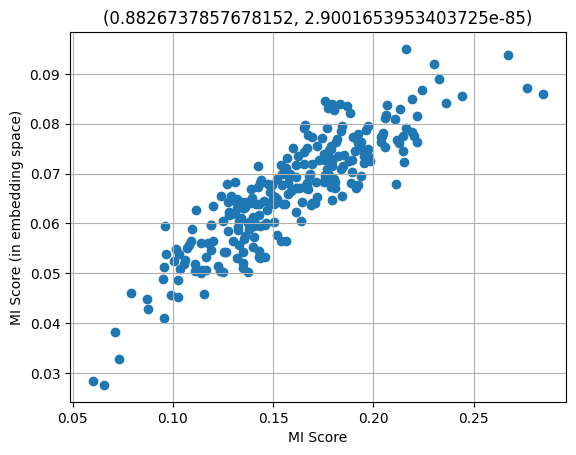

In [79]:
plt.scatter(
    results['layer1']['monosemanticity'],
    z_scores
)
plt.title(corr(
    results['layer1']['monosemanticity'],
    z_scores
))
plt.grid()
plt.xlabel('MI Score')
plt.ylabel('MI Score (in embedding space)')

In [10]:
import umap

In [11]:
Z = umap.UMAP(metric='precomputed').fit_transform(D)

/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [12]:
data_train, _ = get_mei_data(Y, Z, num_train=5, num_test=5)
print(Z.shape, data_train.shape)
z_scores = get_monosemanticity(data_train)
corr(
    results['layer1']['monosemanticity'],
    z_scores
)[0]

(1993, 2) (256, 5, 2)


0.6674344169818993

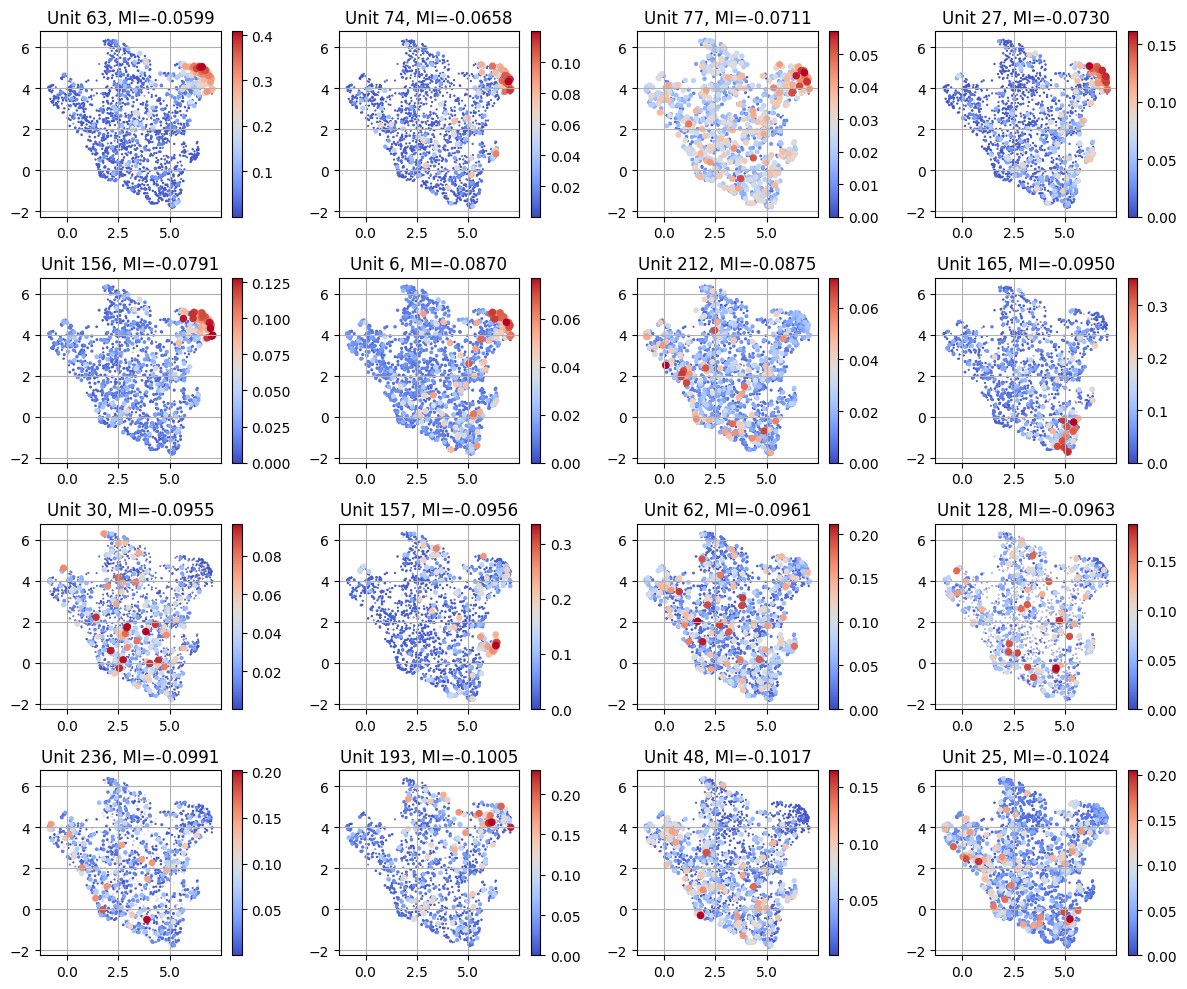

In [13]:
ind_sort = np.argsort(results['layer1']['monosemanticity'])
plt.figure(figsize=(12, 10))
for i in range(16):
    ind = ind_sort[i]
    plt.subplot(4, 4, i + 1)
    c = Y[:, ind].copy()
    ind_sort2 = np.argsort(c)
    plt.scatter(
        *Z[ind_sort2].T, 
        #s=3, 
        s=c[ind_sort2] * 20 / np.max(c),
        c=c[ind_sort2], 
        cmap='coolwarm'
    )
    plt.colorbar()
    plt.grid()
    plt.title('Unit %s, MI=%.4f' % (ind, - results['layer1']['monosemanticity'][ind]))
plt.tight_layout()
plt.show()

In [27]:
# tSNE
Z0 = TSNE(
    n_components=2, 
    #learning_rate='auto', 
    verbose=False,
    metric='precomputed',
    init='random',
    perplexity=10,
    random_state=42,
).fit_transform(D)
data_train0, _ = get_mei_data(Y, Z0, num_train=5, num_test=5)
print(Z0.shape, data_train0.shape)
z_scores0 = get_monosemanticity(data_train0)
print(corr(
    results['layer1']['monosemanticity'],
    z_scores0
)[0])

# PCA
Z1 = u[:, :100].copy()
data_train1, _ = get_mei_data(Y, Z1, num_train=5, num_test=5)
print(Z1.shape, data_train1.shape)
z_scores1 = get_monosemanticity(data_train1)
print(corr(
    results['layer1']['monosemanticity'],
    z_scores1
)[0])

/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


(1993, 2) (256, 5, 2)
0.6653296346129497
(1993, 100) (256, 5, 100)
0.7078982897976549


Text(0, 0.5, 'MI Score (in pca space)')

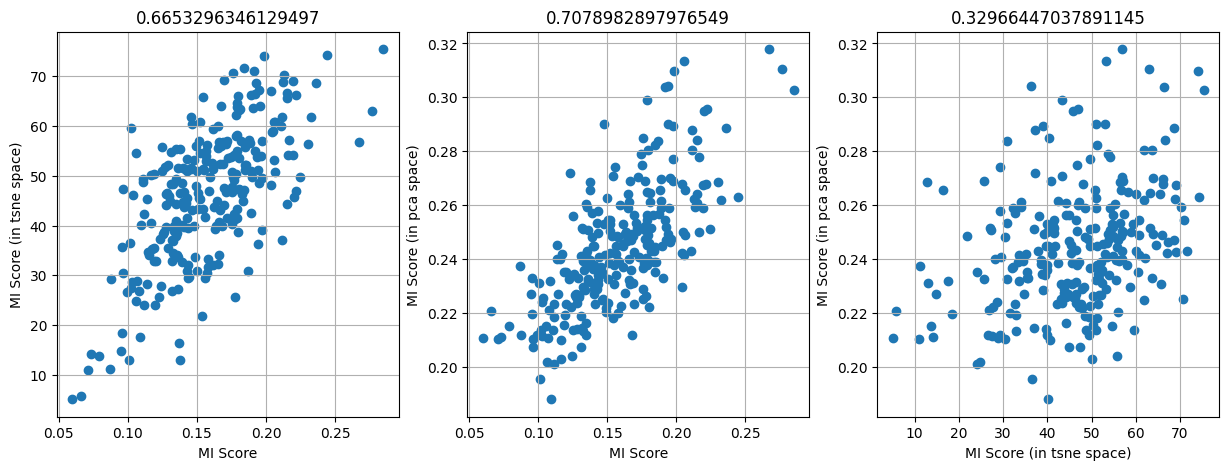

In [30]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(
    results['layer1']['monosemanticity'],
    z_scores0
)
plt.title(corr(
    results['layer1']['monosemanticity'],
    z_scores0
)[0])
plt.grid()
plt.xlabel('MI Score')
plt.ylabel('MI Score (in tsne space)')

plt.subplot(1, 3, 2)
plt.scatter(
    results['layer1']['monosemanticity'],
    z_scores1
)
plt.title(corr(
    results['layer1']['monosemanticity'],
    z_scores1
)[0])
plt.grid()
plt.xlabel('MI Score')
plt.ylabel('MI Score (in pca space)')

plt.subplot(1, 3, 3)
plt.scatter(
    z_scores0,
    z_scores1
)
plt.title(corr(
    z_scores0,
    z_scores1
)[0])
plt.grid()
plt.xlabel('MI Score (in tsne space)')
plt.ylabel('MI Score (in pca space)')

In [33]:
Y.shape

(1993, 256)

In [34]:
# PCA
u, s, v = np.linalg.svd(Y)
Z = u[:, :2].copy()
data_train, _ = get_mei_data(Y, Z, num_train=5, num_test=5)
print(Z.shape, data_train.shape)
z_scores = get_monosemanticity(data_train)
corr(
    results['layer1']['monosemanticity'],
    z_scores
)[0]

    

(1993, 2) (256, 5, 2)


0.09683988453384933

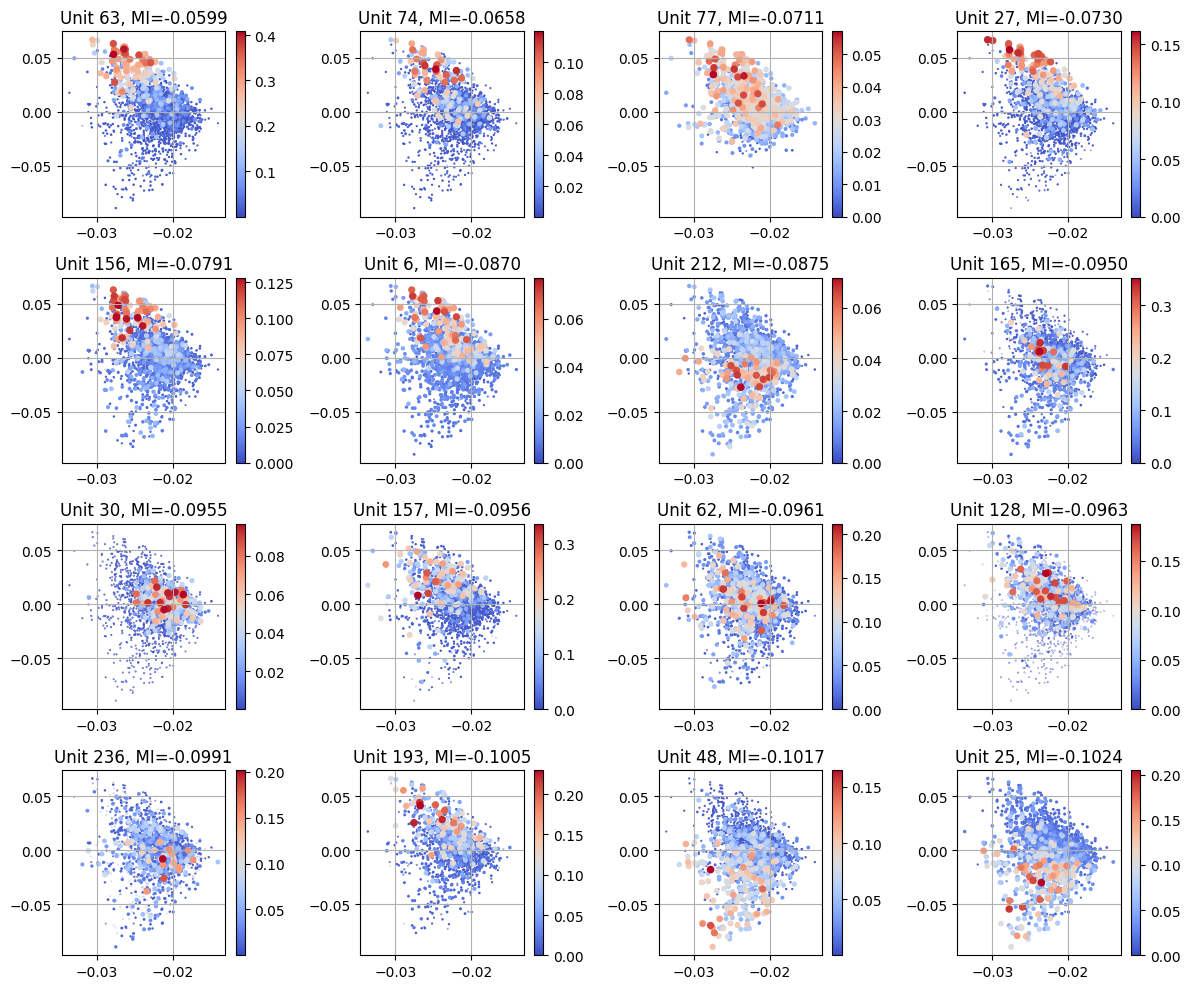

In [35]:
ind_sort = np.argsort(results['layer1']['monosemanticity'])
plt.figure(figsize=(12, 10))
for i in range(16):
    ind = ind_sort[i]
    plt.subplot(4, 4, i + 1)
    c = Y[:, ind].copy()
    ind_sort2 = np.argsort(c)
    plt.scatter(
        *Z[ind_sort2].T, 
        #s=3, 
        s=c[ind_sort2] * 20 / np.max(c),
        c=c[ind_sort2], 
        cmap='coolwarm'
    )
    plt.colorbar()
    plt.grid()
    plt.title('Unit %s, MI=%.4f' % (ind, - results['layer1']['monosemanticity'][ind]))
plt.tight_layout()
plt.show()

Text(0, 0.5, 'MI Score (in embedding space)')

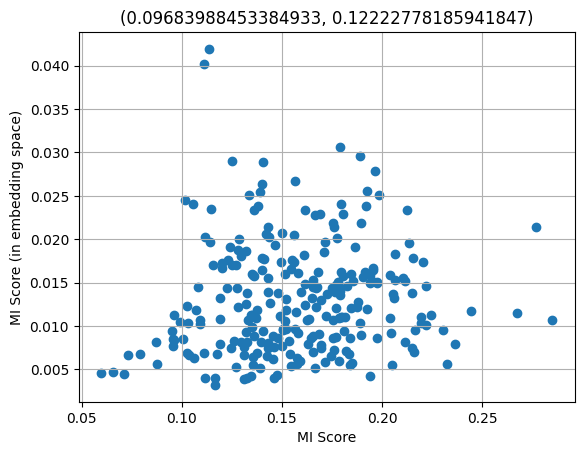

In [36]:
plt.scatter(
    results['layer1']['monosemanticity'],
    z_scores
)
plt.title(corr(
    results['layer1']['monosemanticity'],
    z_scores
))
plt.grid()
plt.xlabel('MI Score')
plt.ylabel('MI Score (in embedding space)')